## Scopus searches of machine learning algorithms in chemistry literature

In this notebook, we search for occurrences of maching learning (ML) algorithm names in literature and visualize the findings. Literature topics are categorized based on the [ACS technical divisions.](https://www.acs.org/content/acs/en/membership-and-networks/join/websites.html) We consider a piece of literature to belong to a division if the title, abstract, or keywords list mention any keyword from the lists written in `acs_divisions.py` These lists contain words found in the titles of symposia for each technical division listed in the "calls for abstracts" for fall and spring ACS national meetings from 2017-2020.

We search for literature with the Scopus API via URL requests. To do the Scopus searches in this notebook (which is optional), you need an API key. [You can get one here.](https://dev.elsevier.com/) Once you get a key, add it to the file `config.json`

In [100]:
import requests
import json
import urllib
import pandas as pd
import numpy as np

from acs_divisions import divisions
from utils import make_df, make_request, get_all_results

# Load configuration, this should contain your API Key
con_file = open("config.json")
config = json.load(con_file)
con_file.close()

Below are the names of machine learning algorithms that we will search. Some names appear in papers that don't explicitly mention ML, thus we have lists that may contain the algorithm name and the words "machine learning."

In [2]:
ml_terms = [['naive bayes'],['bayesian network*'],['genetic algorithm*'],['particle swarm'],['decision tree*'],
           ['random forest*'],['neural network*'],['back propagation','machine learning'],['nearest neigh*','machine learning'],['support vector*'],
           ['regression','machine learning'],['gaussian process','kriging'],['clustering','machine learning']]

In [3]:
years = [[1999,2011],[2010,2021]]

Below is a function to make query strings. This takes a list of keywords, and checks if any or all are found based on the boolean operator provided. A search code is also supplied. The default value is "TITLE-ABS-KEY."

In [4]:
def make_query_string(keywords,boolop="OR",search_code="TITLE-ABS-KEY"):
    """
    Creates a Scopus query string used to search for ANY/ALL
    keyword(s) from a list of keywords in a document's title, abstract, or 
    keyword list using the search code: "TITLE-ABS-KEY"
    """
    qstring = ''
    for i in range(len(keywords)):
        
        if i != len(keywords) - 1:
            qstring += f'\"{keywords[i]}\"' + f' {boolop} '
        
        else:
            qstring += f'\"{keywords[i]}\"'

    qstring = search_code + "(" + qstring + ")"
    
    return qstring

Here we're looping through each division and find occurences of each machine learning algorithm. As mentioned above, some algorithm names need to be searched with the term "machine learning" because those names may occur in documents that aren't related to machine learning, ie. "regression." 

**This step is optional because this cells takes a good amount of time to run. Skip to the cells below the text cell that begins with "! ! ! !" to get the search results.**

In [5]:
#divisions = {'AGFD': divisions['AGFD']}
#divisions = {'AGFD': divisions['AGFD'],'GEOC': divisions['GEOC']}
#ml_terms = [['neural network*']]
#ml_terms = [['neural network*'],['back propagation','machine learning']]
#years = [[1999,2011],[2010,2021]]

In [6]:
df = pd.DataFrame()
results = {}

for year_range in years:
    
    df_dict = {'Year Range' : f'{year_range[0]+1}-{year_range[1]-1}'}
    
    year_dict = {}
    
    for acronym in divisions:
        
        df_dict.update({'Division' : acronym})
    
        division_dict = {}

        for term in ml_terms:

            keywords = divisions[acronym]['keywords']
    
            plain_query = make_query_string(keywords)
        
            if acronym == 'GEOC':
            
                plain_query += " OR " + make_query_string(['mining','geo*'],"AND")
        
            if term[-1] == 'machine learning':
            
                plain_query += " AND " + make_query_string(term,"AND")
            
            else:
            
                plain_query += " AND " + make_query_string(term)
        
            plain_query += f" AND (PUBYEAR > {year_range[0]} AND PUBYEAR < {year_range[1]})"
            request = make_request(plain_query, config['apikey'])
            num_results = request['search-results']['opensearch:totalResults']
            print(year_range, acronym, term[0], num_results)
        
            df_dict.update({term[0] : num_results})
            #df.loc[acronym,term[0]] = num_results
            #df.loc[acronym,'Year Range'] = f'{year_range[0]+1}-{year_range[1]-1}'
        
            division_dict.update({term[0]:request})
        
            #print(plain_query)
            #print()
            
        df = df.append(df_dict,ignore_index=True)
        
        year_dict.update({acronym:division_dict})
        
    results.update({f'{year_range[0]+1}-{year_range[1]-1}':year_dict})


[1999, 2011] AGFD naive bayes 168
[1999, 2011] AGFD bayesian network* 704
[1999, 2011] AGFD genetic algorithm* 3806
[1999, 2011] AGFD particle swarm 349
[1999, 2011] AGFD decision tree* 1640
[1999, 2011] AGFD random forest* 291
[1999, 2011] AGFD neural network* 7576
[1999, 2011] AGFD back propagation 14
[1999, 2011] AGFD nearest neigh* 86
[1999, 2011] AGFD support vector* 3044
[1999, 2011] AGFD regression 217
[1999, 2011] AGFD gaussian process 709
[1999, 2011] AGFD clustering 142
[1999, 2011] AGRO naive bayes 10
[1999, 2011] AGRO bayesian network* 281
[1999, 2011] AGRO genetic algorithm* 1159
[1999, 2011] AGRO particle swarm 106
[1999, 2011] AGRO decision tree* 461
[1999, 2011] AGRO random forest* 59
[1999, 2011] AGRO neural network* 2795
[1999, 2011] AGRO back propagation 2
[1999, 2011] AGRO nearest neigh* 11
[1999, 2011] AGRO support vector* 398
[1999, 2011] AGRO regression 38
[1999, 2011] AGRO gaussian process 1499
[1999, 2011] AGRO clustering 12
[1999, 2011] ANYL naive bayes 116
[1

Saving a CSV file with records of the number of results for each search. This will be used for constructing the visualization.

In [7]:
df.to_csv('search_results.csv')

Saving the raw search results to a JSON file.

In [8]:
with open('search_results.json','w') as out:
    json.dump(results,out)

**! ! ! !** Here you can read the results of the Scopus searches above.

In [5]:
df_search_results = pd.read_csv('search_results.csv')

Here, we're looping through every keyword in `acs_divisions.py` and counting how many times each are found in literature. This helps us identify the top keywords that contribute to our final results. 

**This step is optional because this cells takes a LONG time to run. Skip to the cells below the text cell that begins with "! ! ! !" to get the search results.**

In [6]:
df = pd.DataFrame()
iloc = -1
for year_range in years:
    
    for div in divisions:
        for keyword in divisions[div]['keywords']:
        
            div_dict = {'Division':div,
                        'Keyword':keyword,
                        'Year Range':f'{year_range[0]+1}-{year_range[1]-1}'}

            num_results_total = 0
            for term in ml_terms:
            
                iloc += 1
            
                plain_query = make_query_string([keyword])
            
                if term[-1] == 'machine learning':
                
                    plain_query += " AND " + make_query_string(term,"AND")
                
                else:
                
                    plain_query += " AND " + make_query_string(term)
                
                plain_query += f" AND (PUBYEAR > {year_range[0]} AND PUBYEAR < {year_range[1]})"
                request = make_request(plain_query, config['apikey'])
                num_results = request['search-results']['opensearch:totalResults']
                print(div, f'{year_range[0]+1}-{year_range[1]-1}', keyword, term[0], num_results)
        
                div_dict.update({term[0]:num_results})
                num_results_total += int(num_results)
            
            div_dict.update({'Total':num_results_total})
            df = df.append(div_dict,ignore_index = True)
                
                #print(plain_query)

AGFD 2000-2010 agricultur* naive bayes 10
AGFD 2000-2010 agricultur* bayesian network* 102
AGFD 2000-2010 agricultur* genetic algorithm* 375
AGFD 2000-2010 agricultur* particle swarm 45
AGFD 2000-2010 agricultur* decision tree* 231
AGFD 2000-2010 agricultur* random forest* 23
AGFD 2000-2010 agricultur* neural network* 1051
AGFD 2000-2010 agricultur* back propagation 1
AGFD 2000-2010 agricultur* nearest neigh* 4
AGFD 2000-2010 agricultur* support vector* 201
AGFD 2000-2010 agricultur* regression 15
AGFD 2000-2010 agricultur* gaussian process 425
AGFD 2000-2010 agricultur* clustering 6
AGFD 2000-2010 food naive bayes 5
AGFD 2000-2010 food bayesian network* 82
AGFD 2000-2010 food genetic algorithm* 325
AGFD 2000-2010 food particle swarm 89
AGFD 2000-2010 food decision tree* 249
AGFD 2000-2010 food random forest* 14
AGFD 2000-2010 food neural network* 1125
AGFD 2000-2010 food back propagation 1
AGFD 2000-2010 food nearest neigh* 6
AGFD 2000-2010 food support vector* 288
AGFD 2000-2010 food

Doing a separate search for the number of occurences searching for "mining" AND "geo*"

In [8]:
for year_range in years:
    
    mining_dict = {'Division':'GEOC',
                   'Keyword':'mining',
                   'Year Range':f'{year_range[0]+1}-{year_range[1]-1}'}
    
    num_results_total = 0
    for term in ml_terms:
            
                plain_query = make_query_string(['mining','geo*'],"AND")
            
                if term[-1] == 'machine learning':
                
                    plain_query += " AND " + make_query_string(term,"AND")
                
                else:
                
                    plain_query += " AND " + make_query_string(term)
                    
                plain_query += f" AND (PUBYEAR > {year_range[0]} AND PUBYEAR < {year_range[1]})" 
                request = make_request(plain_query, config['apikey'])
                num_results = request['search-results']['opensearch:totalResults']
                mining_dict.update({term[0]:num_results})
                num_results_total += int(num_results)
                print(f'{year_range[0]+1}-{year_range[1]-1}', term[0], num_results)
                
                #print(plain_query)
            
    mining_dict.update({'Total':num_results_total})
    df = df.append(mining_dict,ignore_index = True)

2000-2010 naive bayes 6
2000-2010 bayesian network* 28
2000-2010 genetic algorithm* 101
2000-2010 particle swarm 16
2000-2010 decision tree* 147
2000-2010 random forest* 11
2000-2010 neural network* 323
2000-2010 back propagation 1
2000-2010 nearest neigh* 9
2000-2010 support vector* 99
2000-2010 regression 14
2000-2010 gaussian process 148
2000-2010 clustering 15
2011-2020 naive bayes 65
2011-2020 bayesian network* 93
2011-2020 genetic algorithm* 226
2011-2020 particle swarm 86
2011-2020 decision tree* 574
2011-2020 random forest* 271
2011-2020 neural network* 867
2011-2020 back propagation 9
2011-2020 nearest neigh* 39
2011-2020 support vector* 462
2011-2020 regression 119
2011-2020 gaussian process 363
2011-2020 clustering 130


In [10]:
df.to_csv('occurences_of_individual_keywords.csv')

**! ! ! !** Here you can read the results of the searches from the above cells.

In [45]:
df_keywords = pd.read_csv('occurences_of_individual_keywords.csv').drop(columns='Unnamed: 0')

Here we find the top five frequently found keywords for each division.

In [46]:
df_top_five = pd.DataFrame()

for div in divisions:
    
    for year_range in years:
        
        year_string = f'{year_range[0]+1}-{year_range[1]-1}'
        five = df_keywords.loc[(df_keywords['Division'] == div) & (df_keywords['Year Range'] == year_string)]['Total'].nlargest(5).index
        five_df = df_keywords.iloc[five][['Division','Year Range','Keyword','Total']]
        df_top_five = pd.concat([df_top_five,five_df])

In [47]:
df_top_five.head(10)

,Division,Year Range,Keyword,Total
45,AGFD,2000-2010,protein*,9909.0
0,AGFD,2000-2010,agricultur*,2489.0
1,AGFD,2000-2010,food,2292.0
9,AGFD,2000-2010,nut*,879.0
36,AGFD,2000-2010,fruit*,776.0
588,AGFD,2011-2020,protein*,18794.0
543,AGFD,2011-2020,agricultur*,14314.0
544,AGFD,2011-2020,food,7517.0
579,AGFD,2011-2020,fruit*,4425.0
552,AGFD,2011-2020,nut*,3888.0


Write new CSV with top fives

In [48]:
df_top_five.to_csv('top_five_keywords.csv')

Now we'll read in the data from the Scopus searches and organize the data for our visualization.

In [49]:
df = pd.read_csv('search_results.csv')

Here we'll split the data into two dataframes, one for each year range.

In [50]:
df00 = df.loc[df['Year Range'] == '2000-2010']
df11 = df.loc[df['Year Range'] == '2011-2020']

Rearranging rows so that they are in order of decreasing average number of occurences.

In [51]:
df00 = df00.reindex(df00.mean(axis=1).sort_values().index[::-1], axis=0)
df11 = df11.reindex(df11.mean(axis=1).sort_values().index[::-1], axis=0)

In [52]:
divisions00 = df00['Division'].values
divisions11 = df11['Division'].values
df00 = df00.drop(labels=['Unnamed: 0','Division','Year Range'], axis=1)
df11 = df11.drop(labels=['Unnamed: 0','Division','Year Range'], axis=1)

Rearranging columns so that they are in order of increasing average number of occurrences.

In [53]:
df00 = df00.reindex(df00.mean().sort_values().index, axis=1)
df11 = df11.reindex(df11.mean().sort_values().index, axis=1)

In [54]:
df00.columns,df11.columns

(Index(['back propagation', 'nearest neigh*', 'clustering', 'naive bayes',
        'regression', 'random forest*', 'particle swarm', 'gaussian process',
        'bayesian network*', 'decision tree*', 'support vector*',
        'genetic algorithm*', 'neural network*'],
       dtype='object'),
 Index(['back propagation', 'nearest neigh*', 'naive bayes', 'clustering',
        'regression', 'bayesian network*', 'gaussian process', 'particle swarm',
        'random forest*', 'decision tree*', 'genetic algorithm*',
        'support vector*', 'neural network*'],
       dtype='object'))

List of ML algorithm names to label the heatmap properly.

In [69]:
ml_terms_formatted00 = ['Back Propagation + ML','Nearest Neighbors + ML','Clustering + ML','Naive Bayes','Regression + ML',
                      'Random Forest','Particle Swarm','Gaussian Process/Kriging','Bayesian Networks','Decision Tree',
                      'Support Vectors','Genetic Algorithms','Neural Networks']

ml_terms_formatted11 = ['Back Propagation + ML','Nearest Neighbors + ML','Naive Bayes','Clustering + ML','Regression + ML',
                      'Bayesian Networks','Gaussian Process/Kriging','Particle Swarm','Random Forest','Decision Tree',
                      'Genetic Algorithms','Support Vectors','Neural Networks']

Extracting the numerical values to a separate array and taking the natural log of the values.

In [56]:
data00 = np.log(df00.values + 1)
data11 = np.log(df11.values + 1)

Reading in top key words from individual searches.

In [57]:
top_key = pd.read_csv('top_five_keywords.csv')

Here we'll construct a dataframe that contains the top five keywords in a more organized manner.

In [58]:
df1 = pd.DataFrame()
for div in divisions:
    
    for year_range in years:
        
        year_string = f'{year_range[0]+1}-{year_range[1]-1}'
    
        div_df = top_key.loc[(top_key['Division'] == div) & (top_key['Year Range'] == year_string)]['Keyword']
    
        df_dict = {'Division':div,
                  'Year Range':year_string}
    
        for i,row in enumerate(div_df):
        
            df_dict.update({str(i+1):[row]})
     
        temp_df = pd.DataFrame(df_dict)
        df1 = pd.concat([df1,temp_df])

In [59]:
df1 = df1.fillna('None')

Saving to CSV

In [60]:
df1.to_csv('top_five_keywords_reformatted.csv')

Constructing a new dataframe that contains percentages with the top keywords

In [61]:
df3 = pd.read_csv('occurences_of_individual_keywords.csv')

In [62]:
df1.loc[df1['Year Range'] == '2000-2010','Total All Keywords'] = (df1.loc[df1['Year Range'] == '2000-2010','Division']
.apply(lambda x: df3.loc[(df3['Division'] == x) & (df3['Year Range'] == '2000-2010')]['Total'].sum()))

df1.loc[df1['Year Range'] == '2011-2020','Total All Keywords'] = (df1.loc[df1['Year Range'] == '2011-2020','Division']
.apply(lambda x: df3.loc[(df3['Division'] == x) & (df3['Year Range'] == '2011-2020')]['Total'].sum()))

df1

,Division,Year Range,1,2,3,4,5,Total All Keywords
0,AGFD,2000-2010,protein*,agricultur*,food,nut*,fruit*,21841.0
0,AGFD,2011-2020,protein*,agricultur*,food,fruit*,nut*,68674.0
0,AGRO,2000-2010,soil,crop*,groundwater,metabolite*,surface water,7858.0
0,AGRO,2011-2020,soil,crop*,groundwater,developing countr*,surface water,31026.0
0,ANYL,2000-2010,sensor*,characterization*,spectroscopy,spectrometry,groundwater,32775.0
...,...,...,...,...,...,...,...,...
0,PROF,2011-2020,chem* education,None,None,None,None,12.0
0,RUBB,2000-2010,rubber*,None,None,None,None,225.0
0,RUBB,2011-2020,rubber*,None,None,None,None,806.0
0,SCHB,2000-2010,chem* sector*,academic entrepreneur*,commercial chem*,science advoca*,None,1.0


In [63]:
df4 = pd.DataFrame()
for year_range in years:
    
    year_string = f'{year_range[0]+1}-{year_range[1]-1}'
    
    for div in divisions:
        
        df_dict = {'Division':div,
                  'Year Range':year_string}
        
        for num in ['1','2','3','4','5']:
            
            div_dict = df1.loc[(df1['Division'] == div) & (df1['Year Range'] == year_string)]
            kw = div_dict[num].values[0]
        
            if kw != 'None': 
                kw_tot = df3.loc[(df3['Division'] == div) & (df3['Year Range'] == year_string) & (df3['Keyword'] == kw)]['Total'].values[0]
                div_tot = div_dict['Total All Keywords'].values[0]
                percentage = np.round(100 * ( kw_tot / div_tot), 1)
                df_dict.update({num:kw+f' ({percentage}%)'})
            
            else:
                df_dict.update({num:'None'})
            
        df4 = df4.append(df_dict, ignore_index=True)

C:\Users\CDG36\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [64]:
df4 = df4[['Division','Year Range','1','2','3','4','5']]
df4.head()

,Division,Year Range,1,2,3,4,5
0,AGFD,2000-2010,protein* (45.4%),agricultur* (11.4%),food (10.5%),nut* (4.0%),fruit* (3.6%)
1,AGRO,2000-2010,soil (46.3%),crop* (16.9%),groundwater (16.1%),metabolite* (4.6%),surface water (4.2%)
2,ANYL,2000-2010,sensor* (57.3%),characterization* (11.8%),spectroscopy (9.5%),spectrometry (4.6%),groundwater (3.9%)
3,BIOT,2000-2010,biochemi* (40.7%),biophysic* (17.1%),systems biology (12.5%),biotechnology (12.0%),bioprocess* (5.2%)
4,BIOL,2000-2010,drug discovery (32.2%),protein folding (31.5%),cytochrome* (13.9%),biosynthesis (11.7%),biomolecule* (6.0%)


In [65]:
df4.to_csv('top_five_keywords_with_percentages.csv')

Finally, we can visualize the results in a heatmap below.

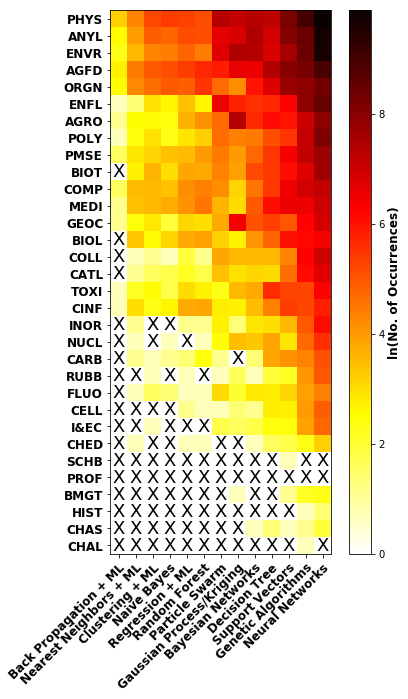

<Figure size 432x288 with 0 Axes>

In [144]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=[20,10])
im = ax.imshow(data00, cmap='hot_r')
#im = ax.pcolor(data, cmap='hot_r', edgecolors='k', linewidths=0.5)

ax.set_xticks(np.arange(len(ml_terms_formatted00)))
ax.set_yticks(np.arange(len(divisions00)))

ax.set_xticklabels(ml_terms_formatted00, fontweight = 'bold', fontsize = 12)
ax.set_yticklabels(divisions00, fontweight = 'bold', fontsize = 12)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.25)

cb = plt.colorbar(im, cax=cax)
cb.set_label(label='ln(No. of Occurrences)',weight='bold',size=12)

for i in range(len(divisions00)):
    for j in range(len(ml_terms_formatted00)):
        if data00[i, j] == 0:
            text = ax.text(j, i, 'X',ha="center", va="center", color="k", size=18)

#table = plt.table(cellText=text_data,loc='upper center',colWidths=[5]*5,rowLabels=divisions)
            
plt.show()
plt.tight_layout()
plt.savefig('heatmap-2000-2010.png',format='png',dpi=600)

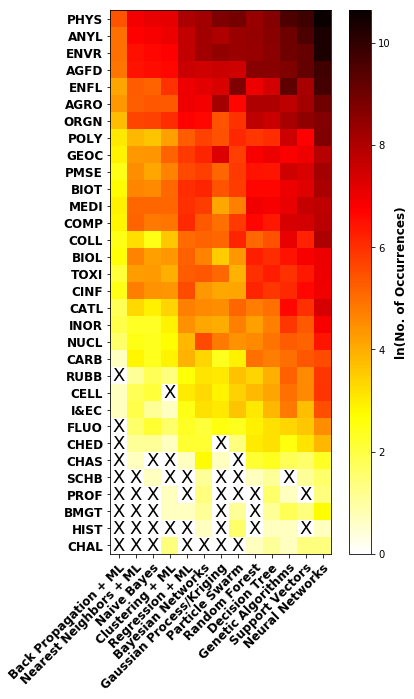

<Figure size 432x288 with 0 Axes>

In [146]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=[20,10])
im = ax.imshow(data11, cmap='hot_r')
#im = ax.pcolor(data, cmap='hot_r', edgecolors='k', linewidths=0.5)

ax.set_xticks(np.arange(len(ml_terms_formatted11)))
ax.set_yticks(np.arange(len(divisions11)))

ax.set_xticklabels(ml_terms_formatted11, fontweight = 'bold', fontsize = 12)
ax.set_yticklabels(divisions11, fontweight = 'bold', fontsize = 12)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.25)

cb = plt.colorbar(im, cax=cax)
cb.set_label(label='ln(No. of Occurrences)',weight='bold',size=12)

for i in range(len(divisions11)):
    for j in range(len(ml_terms_formatted11)):
        if data11[i, j] == 0:
            text = ax.text(j, i, 'X',ha="center", va="center", color="k", size=18)

#table = plt.table(cellText=text_data,loc='upper center',colWidths=[5]*5,rowLabels=divisions)
            
plt.show()
plt.tight_layout()
plt.savefig('heatmap-2011-2020.png',format='png',dpi=600)

A square in the heatmap represents the natural log of the number of occurrences of an ML algorithm name in literature that belong to an ACS division. Squares with an "X" mean that there were zero occurrences. We can observe from this figure that the PHYS division and Neural Networks had the most literature hits, and divisions like HIST, PROF, and CHAL don't have many pieces of literature that mention ML algorithms.

In [117]:
years = np.arange(2000,2021)

selected_divisions = ['PHYS','ANYL','ENVR','AGFD','ENFL','ORGN']

In [101]:
div_dict = {}

for div in selected_divisions:

    divs_kws = divisions[div]['keywords']

    year_num_results = []

    for year in years:
    
        plain_query = make_query_string(divs_kws,boolop="OR",search_code="TITLE-ABS-KEY")
    
        for i,term in enumerate(ml_terms):
    
                    if i == 0:
            
                        mid_text = " AND ("
                
                    else:
                
                        mid_text = " OR "
        
                    if term[-1] == 'machine learning':
            
                        plain_query += mid_text + make_query_string(term,"AND")
            
                    else:
            
                        plain_query += mid_text + make_query_string(term)
        
        plain_query += ")" + f" AND (PUBYEAR = {year})"

        request = make_request(plain_query, config['apikey'])
        num_results = request['search-results']['opensearch:totalResults']
        year_num_results.append(num_results)
        print(div, year, num_results)
        
    div_dict.update({div:year_num_results})

PHYS 2000 1401
PHYS 2001 1360
PHYS 2002 1691
PHYS 2003 2058
PHYS 2004 2792
PHYS 2005 2913
PHYS 2006 3204
PHYS 2007 3922
PHYS 2008 4638
PHYS 2009 5124
PHYS 2010 5170
PHYS 2011 5487
PHYS 2012 5657
PHYS 2013 5961
PHYS 2014 6536
PHYS 2015 7021
PHYS 2016 8141
PHYS 2017 9603
PHYS 2018 12300
PHYS 2019 16251
PHYS 2020 10832
ANYL 2000 1072
ANYL 2001 1111
ANYL 2002 1261
ANYL 2003 1548
ANYL 2004 2054
ANYL 2005 2214
ANYL 2006 2556
ANYL 2007 2978
ANYL 2008 4081
ANYL 2009 4011
ANYL 2010 3953
ANYL 2011 4012
ANYL 2012 4262
ANYL 2013 4520
ANYL 2014 4862
ANYL 2015 5210
ANYL 2016 5961
ANYL 2017 7089
ANYL 2018 9227
ANYL 2019 11953
ANYL 2020 8289
ENVR 2000 976
ENVR 2001 1043
ENVR 2002 1098
ENVR 2003 1441
ENVR 2004 1908
ENVR 2005 2114
ENVR 2006 2429
ENVR 2007 2738
ENVR 2008 3826
ENVR 2009 3724
ENVR 2010 3798
ENVR 2011 3817
ENVR 2012 4090
ENVR 2013 4230
ENVR 2014 4490
ENVR 2015 4799
ENVR 2016 5495
ENVR 2017 6491
ENVR 2018 8579
ENVR 2019 10895
ENVR 2020 7737
AGFD 2000 437
AGFD 2001 468
AGFD 2002 620
AGFD 2003

In [118]:
selected_divisions = np.reshape(np.array(selected_divisions),(2,3))
selected_divisions

array([['PHYS', 'ANYL', 'ENVR'],
       ['AGFD', 'ENFL', 'ORGN']], dtype='<U4')

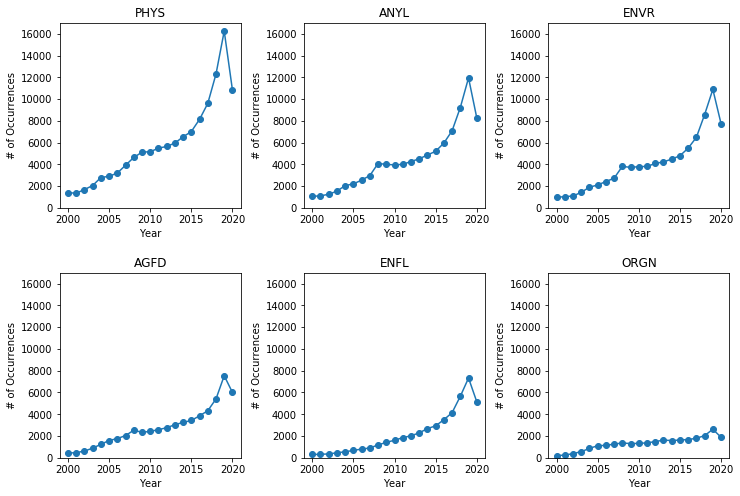

In [142]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[12,8])
fig.subplots_adjust(hspace=0.35,wspace=0.35)
for i in range(2):
    for j in range(3):
        axes[i][j].plot(years,[int(n) for n in div_dict[selected_divisions[i][j]]],'o-')
        axes[i][j].set(title=selected_divisions[i][j],xlabel='Year',ylabel='# of Occurrences',
                      ylim=[0,17000])

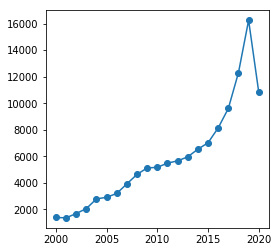

In [97]:
years = [int(y) for y in years]
year_num_results = [int(n) for n in year_num_results]
fig, ax = plt.subplots(figsize=[4,4])
im = ax.plot(years,year_num_results,'o-')